In [1]:
# Just the normal prequisites for using matplotlib and numpy in a Jupyter notebook
%matplotlib inline
# Use the svg backend, in my opinion it just makes better looking plots
%config InlineBackend.figure_format = 'svg'

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='FATAL')
#logger = Logging.setup_logging( logging_level='DEBUG')

import os
import sys
import IPython
from scipy import signal
import scipy.fftpack
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import unittest

#sys.path.append('../../lib/python')
#import Spice2Wav.Spice2Wav as wav

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

directory_path = Path(os.path.abspath('')).resolve()


![module](https://img.shields.io/badge/module-shin%20ey-yellow) ![status](https://img.shields.io/badge/status-work%20in%20progress-orange)

## *shin ey*

<a href="https://photos.app.goo.gl/pg6iZUC32rTKX5LC7"><img src="https://spielhuus.github.io/elektrophon/images/kontrast-logo-tmb.jpg" height="300px" align="right"></a>

***table of contents***

* [*about*](#about)
* [*construction*](#construction)
* [*calibration*](#calibration)
* [*usage*](#usage)
* [*credits*](#credits)
* [*links*](#links)
* [*changelog*](#changelog)
  
<br/><br/><br/><br/>

## *about*

pegel is a voltage controlled amplifier (vca). there are various designs to implement a vca. rod elliott (ESP) has an article on vca techniques [[1][1]]. diy synthesizer modules are usualy designed with an integrated vca chip [[2][2]]  or with a differential amplifier [[3][3]]. the integrated vca chips are either obsolete or rather expensive. the differential amplifier can be built with transistors only. the design has some downsides. even in the simulation the result is not symetryc and has a dc offset from the control voltage. this needs a lot of trimming to get an accurate result. but the biggest downside is, that this design can not do proper amplitude modulation (am). when the carrier signal goes below zero the base signal is completely muted. 

### input mixer

this  is  a pasive input mixer.


In [2]:
#load the input mixer schema
kicad_netlist_path = directory_path.joinpath('main', 'main.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

#simulate input
schema = parser.build_circuit(ground=5)
schema.include(spice_library['BC846B'])
schema.include(spice_library['BC556B'])
schema.include(spice_library['CD4069UBhex'])
schema.include(spice_library['D1N4148'])
schema.V('1', '+15V', schema.gnd, 'DC 15')
schema.V('2', '-15V', schema.gnd, 'DC -15')
schema.V('3', '+5V', schema.gnd, 'DC 5')
#schema.V('4', 'INPUT', schema.gnd, 'DC 0V AC 2V PULSE(-5V +5V 0 1m 1m 0.0001m 2.0001m)')
schema.V('4', 'INPUT', schema.gnd, 'DC 0V AC 2V PULSE(-2V +2V 0 0.0001m 5m 0.0001m 5.0002m)')

class VoltageDivider1(SubCircuitFactory):
    __name__ = 'voltage_divider_1'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, w=0.4):
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )

class VoltageDivider2(SubCircuitFactory):
    __name__ = 'voltage_divider_2'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, w=0.4):
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )

for subcircuit in ( VoltageDivider1(R=500@u_kΩ, w=0.999), VoltageDivider2(R=500@u_kΩ, w=0.1) ):
    schema.subcircuit(subcircuit)

simulator = schema.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=1@u_us, start_time=100@u_ms, end_time=120@u_ms)


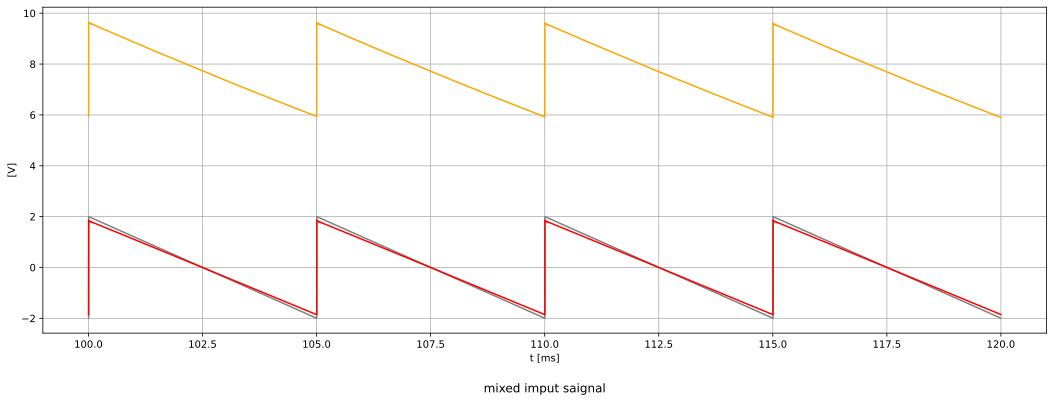

In [3]:
#plot the results
fig, axis = plt.subplots(figsize=(18, 6))

#plot mixed signal
axis.plot(analysis['INPUT'].abscissa*1000, analysis['INPUT'], c='grey') 
axis.plot(analysis['/BAND_PASS_200_900/IN'].abscissa*1000, analysis['/BAND_PASS_200_900/IN'], c='orange') 
axis.plot(analysis['Net-_C4-Pad2_'].abscissa*1000, analysis['Net-_C4-Pad2_'], c='red') 

axis.grid()
axis.set_xlabel('t [ms]')
axis.set_ylabel('[V]')
axis.set_title('mixed imput saignal', y=-0.2)

plt.show()

In [4]:
#load the input mixer schema
#kicad_netlist_path = directory_path.joinpath('main', 'main.cir')
#parser = SpiceParser(path=str(kicad_netlist_path))

#simulate input
#input_mixer = parser.build_circuit(ground=5)
#input_mixer.include(spice_library['BC846B'])
#input_mixer.V('1', '+15V', input_mixer.gnd, 'DC 15')
#input_mixer.V('2', '-15V', input_mixer.gnd, 'DC -15')
#input_mixer.V('3', 'INPUT', input_mixer.gnd, 'DC 0V AC 5V SIN(0 5V 1k)')

#simulator = input_mixer.simulator(temperature=25, nominal_temperature=25)
#analysis_input_mixer = simulator.transient(step_time=1@u_us, start_time=100@u_ms, end_time=110@u_ms)

mixer_max = np.max(np.array(analysis['/BAND_PASS_200_900/IN']))
mixer_min = np.min(np.array(analysis['/BAND_PASS_200_900/IN']))
mixer_average = np.average(np.array(analysis['/BAND_PASS_200_900/IN']))

print( 'Voltages: Max: %f, Min: %f, p2p: %f, Average: %f ' % (mixer_max, mixer_min, mixer_max-mixer_min, mixer_average))


Voltages: Max: 9.654651, Min: 5.902007, p2p: 3.752644, Average: 7.727606 


### filter sections


In [5]:
#load the diffpair schema
#kicad_netlist_path = directory_path.joinpath('main', 'main.cir')
#parser = SpiceParser(path=str(kicad_netlist_path))

In [6]:
#simulate fuzz with a sine wave
#lp = parser.build_circuit(ground=5)
#lp.include(spice_library['BC846B'])
#lp.include(spice_library['BC556B'])
#lp.V('1', '+15V', lp.gnd, 'DC 15')
#lp.V('3', 'INPUT', input_mixer.gnd, 'DC 0V AC 5V SIN(0 5V 500)')

#simulator = lp.simulator(temperature=25, nominal_temperature=25)
#analysis_lp = simulator.transient(step_time=1@u_us, start_time=10@u_ms, end_time=100@u_ms)


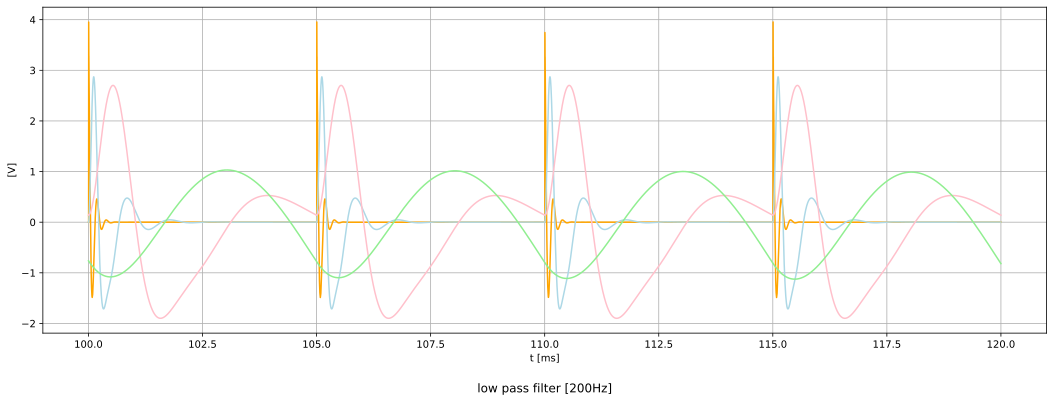

In [7]:
#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))
        
ax0.plot(analysis['/FUZZ_1/IN'].abscissa*1000, analysis['/FUZZ_1/IN'], c='orange')  # differential output
ax0.plot(analysis['/FUZZ_2/IN'].abscissa*1000, analysis['/FUZZ_2/IN'], c='LightBlue')  # differential output
ax0.plot(analysis['/FUZZ_3/IN'].abscissa*1000, analysis['/FUZZ_3/IN'], c='pink')  # differential output
ax0.plot(analysis['/FUZZ_4/IN'].abscissa*1000, analysis['/FUZZ_4/IN'], c='LightGreen')  # differential output

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('[V]')
ax0.set_title('low pass filter [200Hz]', y=-0.2)

plt.show()

In [8]:
analysis_ac = simulator.ac(start_frequency=10@u_Hz, stop_frequency=10@u_kHz, number_of_points=10,  variation='dec')

In [9]:
R1 = 15@u_kOhm
R2 = 15@u_kOhm
C1 = 220@u_nF 
C2 = 22@u_nF
resonant_frequency_4 = 1 / (2 * math.pi * math.sqrt(R1 * R2 * C1 * C2 ))
print( resonant_frequency_4 )

152.512763952991


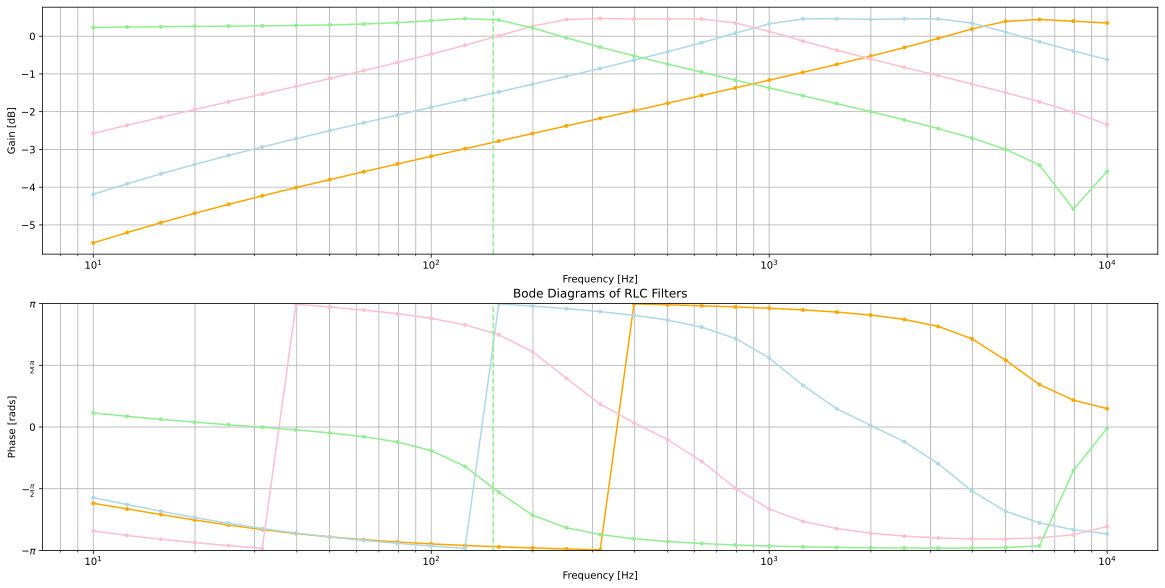

In [10]:
figure, axes = plt.subplots(2, figsize=(20, 10))
plt.title("Bode Diagrams of RLC Filters")
#out = 'Net-_C1-Pad1_'
bode_diagram(axes=axes,
                 frequency=analysis_ac.frequency,
                 gain=np.log10(np.absolute(analysis_ac['/FUZZ_1/IN'])),
                 phase=np.angle(analysis_ac['/FUZZ_1/IN'], deg=False),
                 marker='.',
                 color='orange',
                 linestyle='-',
    )
bode_diagram(axes=axes,
                 frequency=analysis_ac.frequency,
                 gain=np.log10(np.absolute(analysis_ac['/FUZZ_2/IN'])),
                 phase=np.angle(analysis_ac['/FUZZ_2/IN'], deg=False),
                 marker='.',
                 color='LightBlue',
                 linestyle='-',
    )
bode_diagram(axes=axes,
                 frequency=analysis_ac.frequency,
                 gain=np.log10(np.absolute(analysis_ac['/FUZZ_3/IN'])),
                 phase=np.angle(analysis_ac['/FUZZ_3/IN'], deg=False),
                 marker='.',
                 color='pink',
                 linestyle='-',
    )
bode_diagram(axes=axes,
                 frequency=analysis_ac.frequency,
                 gain=np.log10(np.absolute(analysis_ac['/FUZZ_4/IN'])),
                 phase=np.angle(analysis_ac['/FUZZ_4/IN'], deg=False),
                 marker='.',
                 color='LightGreen',
                 linestyle='-',
    )
for axe in axes:
    axe.axvline(x=resonant_frequency_4, color='LightGreen', linestyle='--')


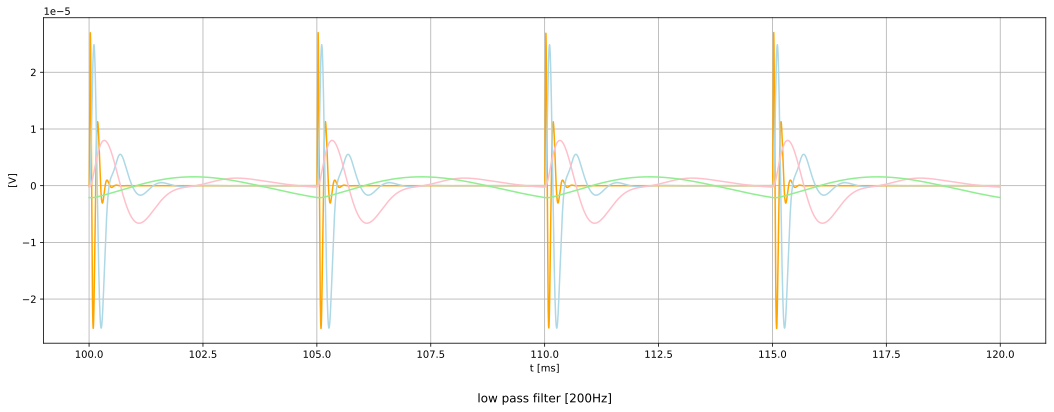

In [11]:
#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))
        
ax0.plot(analysis['OUT_1'].abscissa*1000, analysis['OUT_1'], c='orange')  # differential output
ax0.plot(analysis['OUT_2'].abscissa*1000, analysis['OUT_2'], c='LightBlue')  # differential output
ax0.plot(analysis['OUT_3'].abscissa*1000, analysis['OUT_3'], c='pink')  # differential output
ax0.plot(analysis['OUT_4'].abscissa*1000, analysis['OUT_4'], c='LightGreen')  # differential output

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('[V]')
ax0.set_title('low pass filter [200Hz]', y=-0.2)

plt.show()

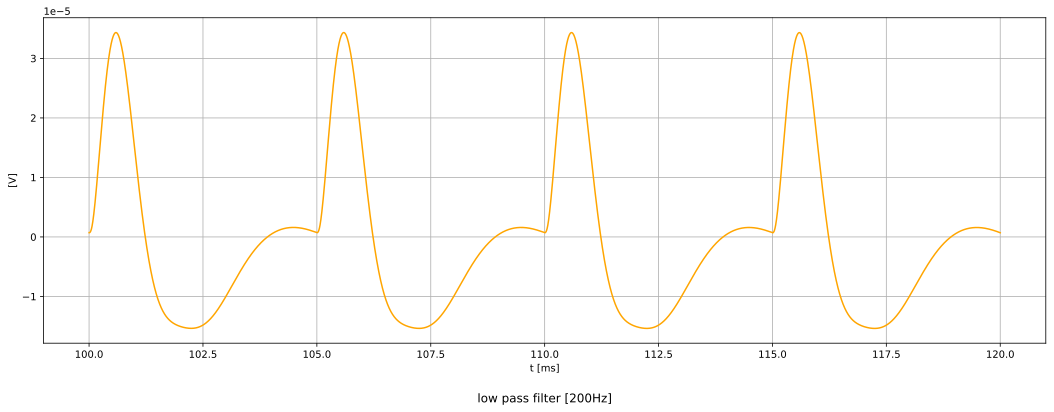

In [12]:
#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))
        
#ax0.plot(analysis['Net-_C19-Pad2_'].abscissa*1000, analysis['Net-_C19-Pad2_'], c='Green')  # differential output
#ax0.plot(analysis['Net-_C21-Pad1_'].abscissa*1000, analysis['Net-_C21-Pad1_'], c='Orange')  # differential output

#ax0.plot(analysis['Net-_C19-Pad2_'].abscissa*1000, analysis['Net-_C31-Pad2_'], c='Green')  # differential output
#ax0.plot(analysis['Net-_C21-Pad1_'].abscissa*1000, analysis['Net-_C35-Pad2_'], c='Orange')  # differential output

ax0.plot(analysis['Net-_C21-Pad1_'].abscissa*1000, analysis['Net-_R57-Pad1_'], c='Orange')  # differential output

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('[V]')
ax0.set_title('low pass filter [200Hz]', y=-0.2)

plt.show()

more promising is it to use a four quadrant multiplier, also known as gilbert cell. the gilbert cell is designed around two differential amplifiers. the carrier signal switches between those. the result is a multiplication of the input voltages. the gilbert cell is mostly used for amplitude modulation in radio transmission. if you look at the integratd circuits like the 633 it can modulate signals up in the gigahertz range. the gilbert cell is not described in all details here, there is a good introduction from w2aew [[4][4]].




this is not real amplitude modulation. when the signal is negative the phase of the output is inverted. this can be adjusted by the bias voltage of the control voltage. the control voltage has to be positive at all time. 


## *construction*

for the final circuit input and output buffering and biasing is needed. the buffering is done with opamps. 


first we design the input stage. the input voltage for the X signal should be 10mV and 20mV for the control voltage.


## *references*

- [VCA Techniques Investigated][1] Rod Elliott (ESP)
- [Popular Electronics][2] Keyiing and VCA citcuits for electronic music instruments 
- [VCA-1][3] Thomas Henry CA3080 vca
- [VCA-3][4] René Schmitz differential pair vca
- [#223][5]: Basics of the Gilbert Cell | Analog Multiplier | Mixer | Modulator
- [#224][6]: AM & DSB-SC Modulation with the Gilbert Cell
- [Analog Devices][8]: Analog multiplier application guide 
- [AD633][9]: Datasheet 




[1]: https://static1.squarespace.com/static/5e6e99e8bd2f8a6de8454feb/t/5e77db16e8ff44374c24b124/1584913176675/MBD+BOM+and+build.pdf
[2]: https://www.diystompboxes.com/smfforum/index.php?topic=118397.0
[3]: https://www.diystompboxes.com/smfforum/index.php?topic=99779.0



